In [200]:
from coders import BitStream, WavStream
from coders import SimplePSK as Coder
import scipy.io.wavfile

In [201]:
input_stream = BitStream(np.random.randint(2, size=20))
encoded = Coder.encode(input_stream)
scipy.io.wavfile.write('test.wav', Coder.rate.current, encoded)
read_rate, read = scipy.io.wavfile.read('test.wav')
noisy = np.random.normal(0, 1, len(read)) * 0.2 + read

In [202]:
wavstream = WavStream(noisy, read_rate, int(round(Coder.rate.current * Coder.symbol_duration.current)))
verification = input_stream.assymbolsize(2)
decoded = Coder.decode(read_rate, wavstream)
# check = verification == decoded

Main vars: 1000 10000 100
Filter vars: 50 0.5 25
Peak vars: 20 1 [20]
Zeroes vars: 20


Length: 10000


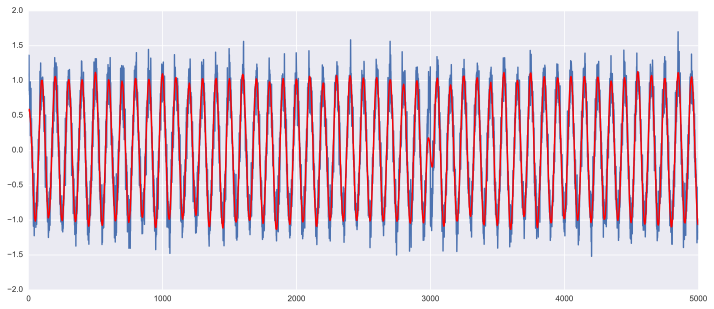

In [203]:
lim = (0, 5000)
sns.tsplot(wavstream[lim[0]:lim[1]])
sns.tsplot(wavstream.filter(50, 0.5, 20)[lim[0]:lim[1]], color='r')
print('Length:', len(wavstream))
# print('Quality:', check.sum()/len(check))

In [267]:
from coders import val_split

cls = Coder
rate = read_rate
stream = noisy

# Prepare main variables
f = cls.frequency.current
r = rate
period = r/f
symbol_size = cls.symbol_size.current
symbol_len = int(round(rate * cls.symbol_duration.current))
stream_len = len(stream)
levels = 2**symbol_size
shifts = np.linspace(0, 1, levels+1)
stream = WavStream(stream, r, symbol_len)
print('Main vars:', symbol_len, len(stream), round(period))

# Filter stream
f_window = cls.filter_window_base.current + \
           int(round(r * cls.filter_window_scale.current / f))
f_shape = cls.filter_shape.current  # type: float
f_std = cls.filter_std_base.current + \
        int(round(r * cls.filter_std_scale.current / f))
stream = stream.filter(f_window, f_shape, f_std)
print('Filter vars:', f_window, f_shape, f_std)

# Peak detection
pw_start = int(round(r * cls.peak_width_start.current / f))
pw_span = max(1, int(round(r * cls.peak_width_span.current / f)))
pw_range = np.arange(pw_start, pw_start + pw_span)
peak_thresh = cls.peak_threshold.current
peaks = stream.peaks(pw_range, peak_thresh)
positives = [i for i, v in peaks if v > 0]
negatives = [i for i, v in peaks if v < 0]
positives = val_split(positives, symbol_len, stream_len, size=True)
negatives = val_split(negatives, symbol_len, stream_len, size=True)
negatives_stream = BitStream([(((n % period / period + 0.25) % 1 * levels).round().astype(int) % levels).mean().astype(int) for n in negatives], symbolsize=symbol_size)
positives_stream = BitStream([(((n % period / period + 0.25) % 1 * levels).round().astype(int) % levels).mean().astype(int) for n in positives], symbolsize=symbol_size)
print('Peak vars:', pw_start, pw_span, pw_range)

# Zeroes detection
# TODO: zeroes reinforcement
zeroes_width = int(round(r * cls.zeroes_width.current / f))
zeroes_threshold = cls.zeroes_threshold.current
zeroes = stream.zeroes(zeroes_width, zeroes_threshold)
zeroes = val_split(zeroes, symbol_len, stream_len, size=True)
print('Zeroes vars:', zeroes_width)

Main vars: 1000 10000 100
Filter vars: 50 0.5 25
Peak vars: 20 1 [20]
Zeroes vars: 20


In [268]:
input_stream.assymbolsize(2)

BitStream([3, 3, 3, 1, 1, 1, 0, 0, 3, 0], symbolsize=2)

In [270]:
negatives_stream == input_stream.assymbolsize(2)

BitStream([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool,
symbolsize=2)

In [224]:
def get_shift(peaks, offset, period):
    normalised = peaks % period / period + offset
    return normalised

In [230]:
negatives[0] % period / period

array([ 0.5 ,  0.5 ,  0.5 ,  0.49,  0.5 ,  0.49,  0.49,  0.5 ,  0.5 ])

In [231]:
negatives[1] % period / period

array([ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5])

In [232]:
negatives[-1] % period / period

array([ 0.74,  0.74,  0.74,  0.74,  0.74,  0.74,  0.74,  0.74,  0.75])

In [264]:
for n in range(10):
    print((((negatives[n] % period / period + 0.25) % 1 * levels).round().astype(int) % levels).mean().astype(int))
    print(input_stream.assymbolsize(2)[n])

3
3
3
3
3
3
1
1
1
1
1
1
0
0
0
0
3
3
0
0


In [279]:
negatives_stream = [((n % period / period + 0.25) % 1 * levels)
                            for n in negatives]

[autoreload of coders failed: Traceback (most recent call last):
  File "C:\Python\3.5.1\lib\site-packages\IPython\extensions\autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Alen\PycharmProjects\pipeline\coders\__init__.py", line 413
    peaks_stream =
                 ^
SyntaxError: invalid syntax
]


In [280]:
positives_stream = [((p % period / period + 0.25) % 1 * levels)
                            for p in positives]

In [281]:
negatives_stream

[array([ 3.  ,  3.  ,  3.  ,  2.96,  3.  ,  2.96,  2.96,  3.  ,  3.  ]),
 array([ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.]),
 array([ 3.  ,  3.  ,  3.  ,  3.  ,  3.  ,  3.  ,  2.96,  3.  ,  3.  ]),
 array([ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  0.96,  0.96,  1.  ,  1.  ]),
 array([ 1.  ,  1.  ,  1.  ,  1.  ,  0.96,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ]),
 array([ 1.  ,  0.96,  1.  ,  1.  ,  0.96,  1.  ,  1.  ,  1.  ,  0.96]),
 array([ 0.  ,  3.96,  3.96,  0.  ,  3.96,  3.96,  3.96,  0.  ,  0.  ,  3.96]),
 array([ 3.92,  0.  ,  3.96,  0.  ,  0.  ,  3.96,  0.  ,  3.96,  3.96]),
 array([ 3.  ,  3.  ,  2.96,  2.96,  2.96,  3.  ,  3.  ,  2.96,  2.96]),
 array([ 3.96,  3.96,  3.96,  3.96,  3.96,  3.96,  3.96,  3.96,  0.  ])]

In [282]:
positives_stream

[array([ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  0.96,  0.96,  0.96,  1.  ]),
 array([ 1.  ,  1.  ,  1.  ,  1.  ,  0.96,  1.  ,  1.04,  1.  ,  1.04,  1.  ]),
 array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 array([ 3.  ,  2.96,  3.  ,  3.  ,  3.  ,  3.  ,  2.96,  3.  ,  3.  ]),
 array([ 3.  ,  3.  ,  3.  ,  3.  ,  3.  ,  2.96,  3.  ,  3.  ,  3.  ,  3.  ]),
 array([ 3.  ,  2.96,  3.  ,  3.  ,  2.96,  3.  ,  3.  ,  3.  ,  2.96]),
 array([ 2.  ,  1.96,  2.  ,  1.96,  1.96,  1.96,  1.96,  2.  ,  1.96]),
 array([ 1.92,  1.96,  2.  ,  1.96,  2.  ,  1.96,  1.96,  1.96,  1.96,  1.96]),
 array([ 0.96,  1.  ,  1.  ,  0.96,  0.96,  0.96,  1.  ,  1.  ,  0.96]),
 array([ 1.96,  1.96,  1.96,  1.96,  1.96,  1.96,  1.96,  1.96,  1.96])]

In [296]:
[np.concatenate(s) for s in zip(negatives_stream, positives_stream)]

[array([ 3.  ,  3.  ,  3.  ,  2.96,  3.  ,  2.96,  2.96,  3.  ,  3.  ,
         1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  0.96,  0.96,  0.96,  1.  ]),
 array([ 3.  ,  3.  ,  3.  ,  3.  ,  3.  ,  3.  ,  3.  ,  3.  ,  3.  ,
         1.  ,  1.  ,  1.  ,  1.  ,  0.96,  1.  ,  1.04,  1.  ,  1.04,  1.  ]),
 array([ 3.  ,  3.  ,  3.  ,  3.  ,  3.  ,  3.  ,  2.96,  3.  ,  3.  ,
         1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ]),
 array([ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  0.96,  0.96,  1.  ,  1.  ,
         3.  ,  2.96,  3.  ,  3.  ,  3.  ,  3.  ,  2.96,  3.  ,  3.  ]),
 array([ 1.  ,  1.  ,  1.  ,  1.  ,  0.96,  1.  ,  1.  ,  1.  ,  1.  ,
         1.  ,  3.  ,  3.  ,  3.  ,  3.  ,  3.  ,  2.96,  3.  ,  3.  ,
         3.  ,  3.  ]),
 array([ 1.  ,  0.96,  1.  ,  1.  ,  0.96,  1.  ,  1.  ,  1.  ,  0.96,
         3.  ,  2.96,  3.  ,  3.  ,  2.96,  3.  ,  3.  ,  3.  ,  2.96]),
 array([ 0.  ,  3.96,  3.96,  0.  ,  3.96,  3.96,  3.96,  0.  ,  0.  ,
         3.96,  2.  ,  1.96,  2.  , 

In [286]:
list(zip([1, 2, 3], [4, 5, 6]))

[(1, 4), (2, 5), (3, 6)]

In [295]:
np.concatenate((np.array([0, 1, 2]), np.array([0, 2, 3])))

array([0, 1, 2, 0, 2, 3])